# ICELL88 Demo with Second Dataset
This notebook runs the first demo with Wafergen ICELL88 demo run. We have three cells, Embryoning ESC which has two replicates, ESC2, ESC3 and Differentiated d1 and d2 stages, which again have two replicates d1.2, d1.3 and d2.2, d2.3. 

This demo maps with the transcripts of `mm9`. 

In [2]:
import subprocess, os, csv, signal, pysam, rpy2
import numpy as np
import matplotlib.pyplot as plt
import readline
import rpy2.robjects
from matplotlib.pyplot import *
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
%load_ext rpy2.ipython

In [6]:
%%R
library(Rtsne)
library(DESeq2)
library(ggplot2)
library(lattice)
library(GGally)
library(genefilter)
library(plyr)
library(M3Drop)
library(scde)
library(monocle)
library(reshape)

In [103]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [23]:
%%R
mappingSummary <- read.csv('/home/baker/Rna-seq_Data-Analysis/ICELL8_Rep2/mappingSummaryMod.csv',sep=',', row.names=1)
head(mappingSummary)

            CellType Number_of_input_reads Uniquely_mapped_reads_number
GGTTACTCGGC     d2.2                     5                            2
GTCGTCGCATC     d2.2                    25                           12
GGCTGGTAGGT     ESC2                    42                           28
CCAGTTCAGGA     d2.3                   372                          224
AGAACGAAGCT     d2.2                   419                          271
CCGGCTCGACC     d1.3                   451                          223


In [26]:
%%R
mappingSummary$CellName <- make.names(mappingSummary$CellType, unique=TRUE)
head(mappingSummary)

            CellType Number_of_input_reads Uniquely_mapped_reads_number
GGTTACTCGGC     d2.2                     5                            2
GTCGTCGCATC     d2.2                    25                           12
GGCTGGTAGGT     ESC2                    42                           28
CCAGTTCAGGA     d2.3                   372                          224
AGAACGAAGCT     d2.2                   419                          271
CCGGCTCGACC     d1.3                   451                          223
            CellName
GGTTACTCGGC     d2.2
GTCGTCGCATC   d2.2.1
GGCTGGTAGGT     ESC2
CCAGTTCAGGA     d2.3
AGAACGAAGCT   d2.2.2
CCGGCTCGACC     d1.3


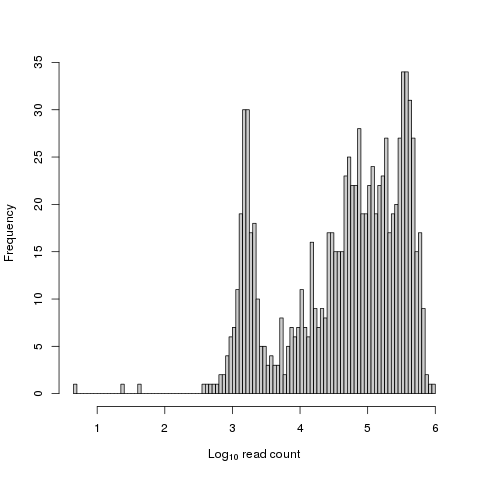

In [10]:
%%R
hist(log10(mappingSummary$Number_of_input_reads), breaks=100, main="", col='grey80',
    xlab=expression(Log[10]~"read count"))

In [20]:
%%R
icell8_stats <- read.csv('icell8_stats.tsv', sep='\t', header=T)
rownames(icell8_stats) <- icell8_stats$X.Barcode
head(icell8_stats)

              X.Barcode Sample Nreads Unique_UMIs Nreads_quality_filtered
AACCTTCCTTA AACCTTCCTTA   ESC2  92151       46811                   74127
AACGAACGCTC AACGAACGCTC   ESC2 100858       52671                   78329
AACCAATCGTC AACCAATCGTC   d1.2 463128      215989                  351874
AACCAACGCAA AACCAACGCAA   d1.2  68747       38417                   54683
AACGCCAAGAC AACGCCAAGAC   ESC2 100975       56948                   79209
AACCGCCTAAC AACCGCCTAAC   d1.2 166452       87717                  130235
            Unique_UMIs_quality_filtered Nreads_trimmed Unique_UMIs_trimmed
AACCTTCCTTA                        41332          70127               38927
AACGAACGCTC                        45278          74004               42481
AACCAATCGTC                       185283         339129              179026
AACCAACGCAA                        33083          51003               30345
AACGCCAAGAC                        48860          73690               44920
AACCGCCTAAC               

We now read the htseq counts

In [15]:
%%R
cd <- read.csv('/home/baker/Rna-seq_Data-Analysis/ICELL8_Rep2/AllHtseqCounts_rep2_Modified.tsv', sep='\t', row.names=1)

In [31]:
%%R
dim(cd)

[1] 48023   923


In [30]:
%%R
geneName <- read.csv('/home/baker/Rna-seq_Data-Analysis/ICELL8_Rep2/mouseGeneName.txt', header=F)
tail(geneName)

                 V1
48018  Olfr1473-ps1
48019 RP23-410K18.1
48020   RP23-60N8.3
48021 RP23-416P14.1
48022 RP23-371K18.1
48023  RP23-17C12.2


In [33]:
%%R
rownames(cd) <- make.names(geneName$V1, unique=TRUE)

In [129]:
%%R
cdFilt <- clean.counts(cd, min.lib.size = 1200, min.reads = 8, min.detected = 4)

In [130]:
%%R
print(dim(cd))
print(dim(cdFilt))

[1] 48023   923
[1] 20418   496


Above are all the report column files

In [131]:
%%R
mappingFilt <- mappingSummary[colnames(cdFilt),]
dim(mappingFilt)

[1] 496   4


In [132]:
%%R
print('Before Filtering:')
print(table(mappingSummary$CellType))
print('After Filtering:')
print(table(mappingFilt$CellType))

[1] "Before Filtering:"

d1.2 d1.3 d2.2 d2.3 ESC2 ESC3 
 193  157  156  116  141  160 
[1] "After Filtering:"

d1.2 d1.3 d2.2 d2.3 ESC2 ESC3 
 102    4  133  115   54   88 


In [133]:
%%R
norm_factor_cpm <- rowSums(cdFilt) / 1000000
cdFilt_cpm <- cdFilt / norm_factor_cpm

In [134]:
%%R
cdFilt_cpm_log2plus1 <- log2(cdFilt_cpm+1)

In [135]:
%%R
FinalPCAData <- t(cdFilt_cpm_log2plus1)
pcaPRComp <- prcomp(FinalPCAData)

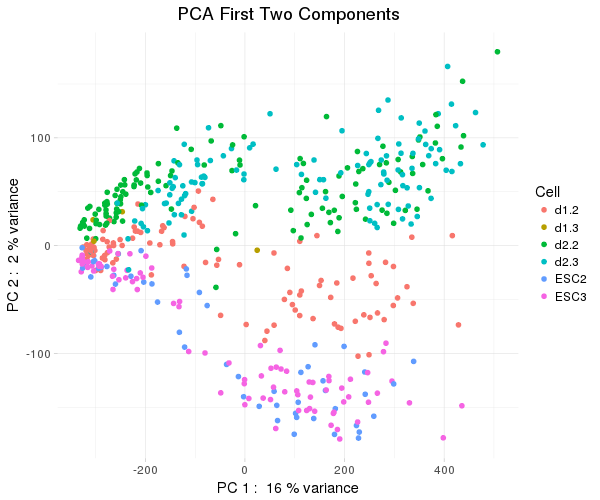

In [136]:
%%R -w 600 -h 500
sampleCondition <- mappingFilt$CellType
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [137]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)


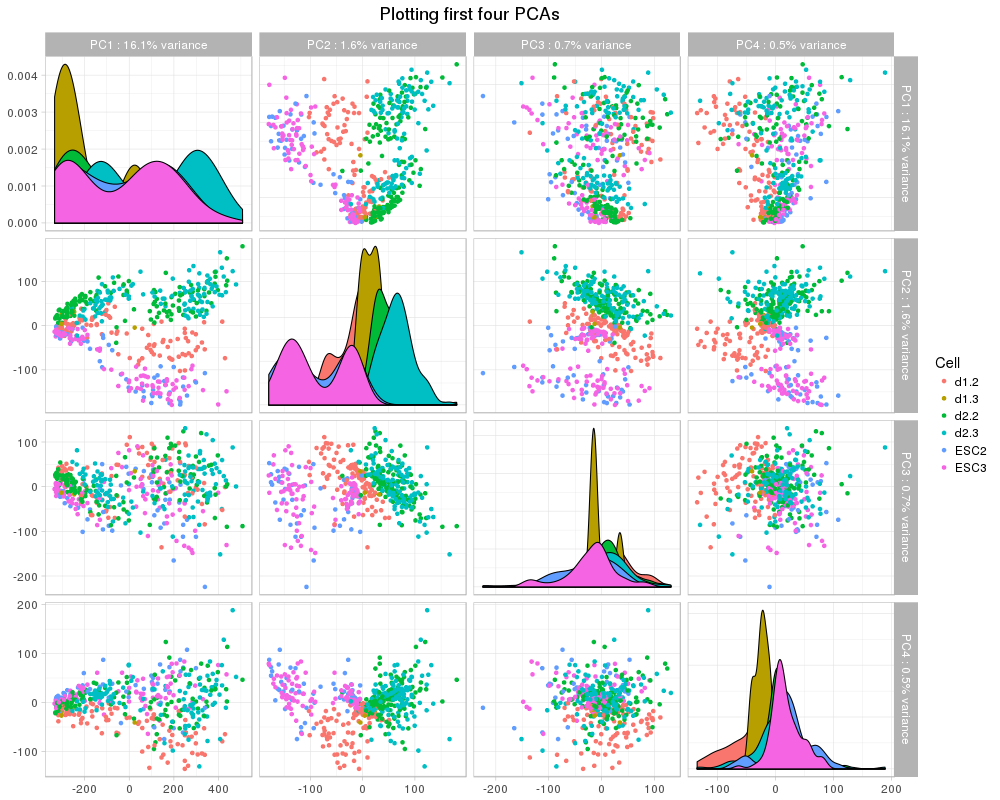

In [138]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

In [139]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

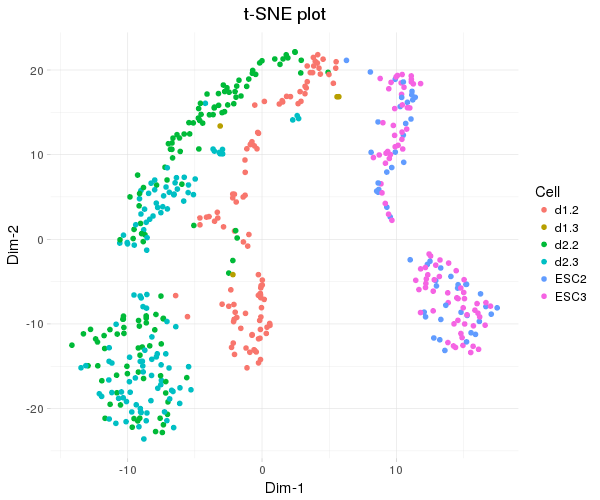

In [140]:
%%R -w 600 -h 500
sampleCondition <- mappingFilt$CellType
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

## Generating trajectory

In [141]:
%%R
cellPhenoData <- data.frame(cells= colnames(cdFilt), celltype=mappingFilt$CellType)
count_matrix <- cdFilt
geneNames <- rownames(cdFilt)

In [142]:
%%R
pd <- new("AnnotatedDataFrame", data = cellPhenoData)
rownames(pd) <- cellPhenoData$cells

In [143]:
%%R
fd <- new("AnnotatedDataFrame", data = as.data.frame(geneNames))
rownames(fd) <- fd$geneNames

In [144]:
%%R
ICELL8 <- newCellDataSet(as.matrix(count_matrix),
                              phenoData = pd,
                              featureData = fd,
                              expressionFamily=negbinomial())

In [145]:
%%R
ICELL8 <- estimateSizeFactors(ICELL8)
ICELL8 <- estimateDispersions(ICELL8)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Removing 452 outliers

  warnings.warn(x, RRuntimeWarning)


In [146]:
%%R
ICELL8  <- detectGenes(ICELL8 , min_expr = 0.1)
print(head(fData(ICELL8)))
expressed_genes <- row.names(subset(fData(ICELL8), num_cells_expressed >= 20))

      geneNames num_cells_expressed
Gnai3     Gnai3                 251
Cdc45     Cdc45                 163
Scml2     Scml2                  12
Narf       Narf                  49
Klf6       Klf6                 169
Scmh1     Scmh1                  24


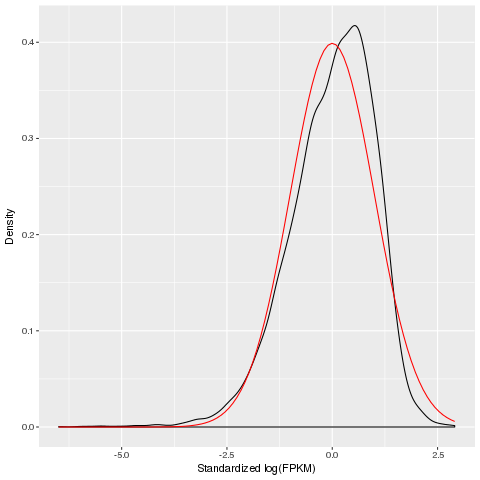

In [147]:
%%R
L <- log(exprs(ICELL8))
# Standardize each gene, so that they are all on the same scale,
# Then melt the data with plyr so we can plot it easily"
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))
# Plot the distribution of the standardized gene expression values.
qplot(value, geom="density", data=melted_dens_df) +  stat_function(fun = dnorm, size=0.5, color='red') +xlab("Standardized log(FPKM)") +ylab("Density")


In [148]:
%%R
table(pData(ICELL8)$celltype)


d1.2 d1.3 d2.2 d2.3 ESC2 ESC3 
 102    4  133  115   54   88 


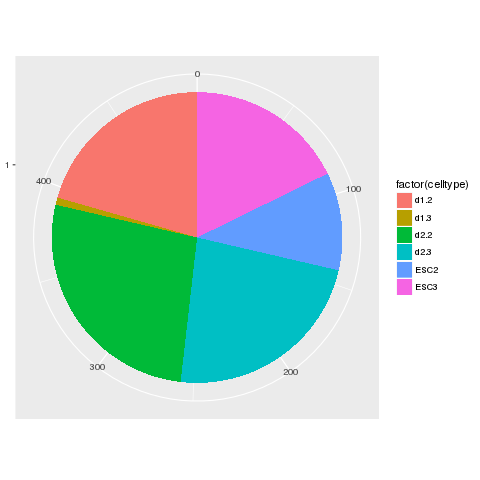

In [149]:
%%R
pie <- ggplot(pData(ICELL8), aes(x = factor(1), fill = factor(celltype))) +
geom_bar(width = 1)
pie + coord_polar(theta = "y") +
theme(axis.title.x=element_blank(), axis.title.y=element_blank())

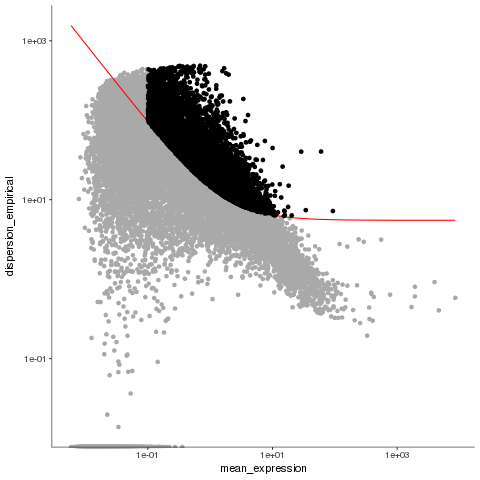

In [150]:
%%R
disp_table <- dispersionTable(ICELL8)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)
ICELL8 <- setOrderingFilter(ICELL8, unsup_clustering_genes$gene_id)
plot_ordering_genes(ICELL8)

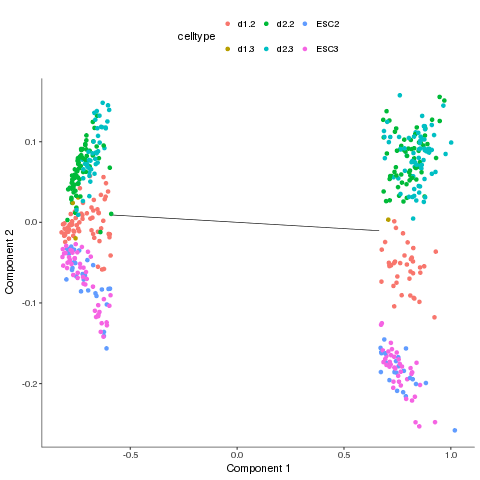

In [151]:
%%R
ICELL8 <- clusterCells(ICELL8, num_clusters=2)
plot_cell_trajectory(ICELL8, 1, 2, color="celltype")

In [152]:
%%R
disp_table <- dispersionTable(ICELL8)
ordering_genes <- subset(disp_table,
mean_expression >= 0.5 &
dispersion_empirical >= 2 * dispersion_fit)$gene_id

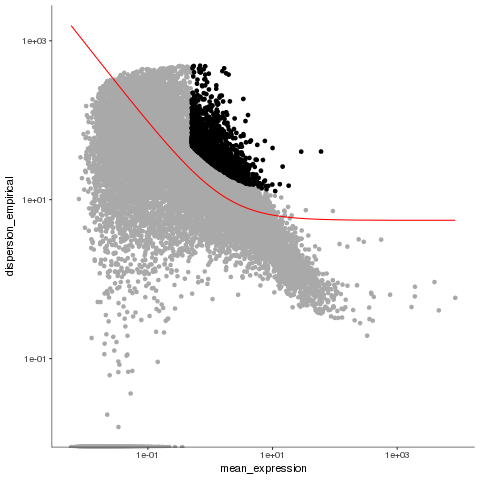

In [153]:
%%R
ICELL8 <- setOrderingFilter(ICELL8, ordering_genes)
plot_ordering_genes(ICELL8)

In [154]:
%%R
ICELL8 <- reduceDimension(ICELL8, max_components=2)

In [163]:
%%R
ICELL8 <- orderCells(ICELL8, reverse=FALSE)
# have to call the orderCells once before setting the root state
ICELL8 <- orderCells(ICELL8, root_state = 11, reverse=TRUE)

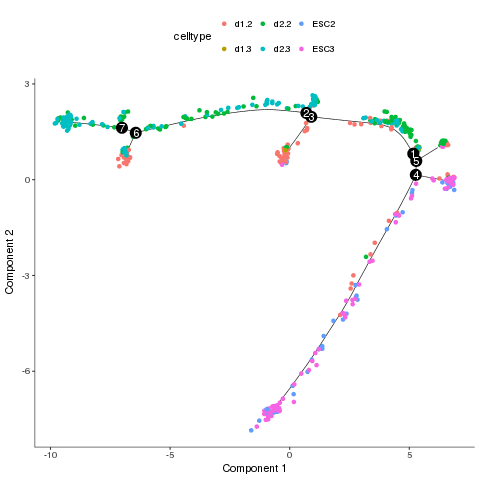

In [164]:
%%R
plot_cell_trajectory(ICELL8, color_by="celltype")

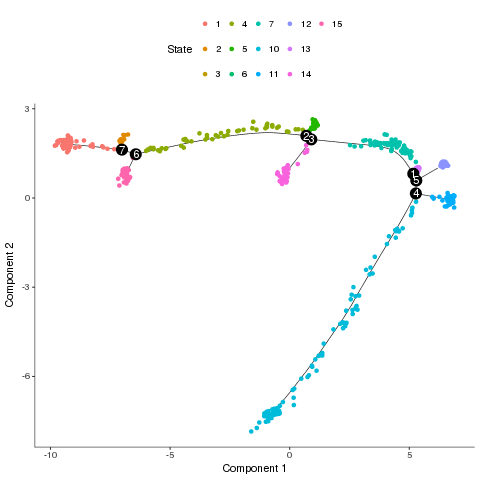

In [165]:
%%R
plot_cell_trajectory(ICELL8, color_by="State")

In [158]:
%%R
ICELL8_expressed_genes <-  row.names(subset(fData(ICELL8), num_cells_expressed >= 20))
ICELL8_filtered <-ICELL8[ICELL8_expressed_genes,]
my_genes <- row.names(subset(fData(ICELL8_filtered),geneNames %in% c('Nanog','Klf4','Sox2','esrrb')))
cds_subset <- ICELL8_filtered[my_genes,]

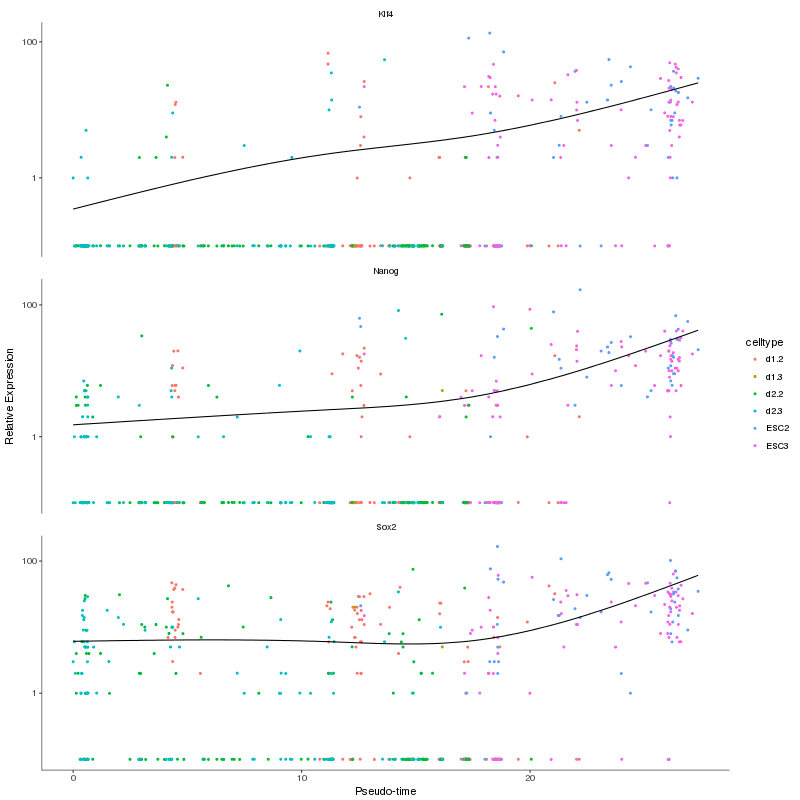

In [159]:
%%R -w 800 -h 800
plot_genes_in_pseudotime(cds_subset, color_by="celltype")